In [1]:
# Import libraries and load the experimental settings.

import hypergraph, hyperneo, comm_vis
settings = comm_vis.read_settings()

In [2]:
# The object named 'settings' stores the order of node labels, the set of node label names, 
# the order of inferred communities, the hyperparameter set for each empirical hypergraph, and the random seed.

import json
print(json.dumps(settings, indent=2))

{
  "random_state": 42,
  "workplace": {
    "label_name": [
      "DISQ",
      "DMCT",
      "DSE",
      "SFLE",
      "SRH"
    ],
    "label_order": [
      0,
      1,
      2,
      3,
      4
    ],
    "community_order": [
      0,
      4,
      1,
      2,
      3
    ],
    "hyperparam": [
      5,
      0.9
    ]
  },
  "hospital": {
    "label_name": [
      "ADM",
      "MED",
      "NUR",
      "PAT"
    ],
    "label_order": [
      0,
      1,
      2,
      3
    ],
    "community_order": [
      1,
      0
    ],
    "hyperparam": [
      2,
      0.4
    ]
  },
  "contact-high-school": {
    "label_name": [
      "2BIO1",
      "2BIO2",
      "2BIO3",
      "MP*1",
      "MP*2",
      "PSI*",
      "PC",
      "PC*",
      "MP"
    ],
    "label_order": [
      0,
      1,
      2,
      8,
      3,
      4,
      6,
      7,
      5
    ],
    "community_order": [
      5,
      4,
      1,
      6,
      3,
      8,
      2,
      0,
      7
    ],
    "hyperpara

In [3]:
# Load a data set. 
# Specify "workplace", "hospital", "high-school", or "primary-school" as data_name. 
# In this example, specify the workplace data set.

data_name = "workplace"
#data_name = "hospital"
#data_name = "contact-high-school"
#data_name = "contact-primary-school"

G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

Number of nodes: 92
Number of hyperedges: 788
Average degree of the node: 17.652173913043477
Average size of the hyperedge: 2.0609137055837565
Maximum size of the hyperedge: 4
Number of different node lables: 5



In [4]:
# Set of node label names

settings[data_name]["label_name"]

['DISQ', 'DMCT', 'DSE', 'SFLE', 'SRH']

In [5]:
# Order of the node labels

settings[data_name]["label_order"]

[0, 1, 2, 3, 4]

In [8]:
# Set the random seed and the hyperparameters.

random_state = settings["random_state"]
(K, gamma) = settings[data_name]["hyperparam"]

print(random_state, K, gamma)

42 5 0.9


In [9]:
# Fit the latent parameters of HyperNEO to the data.

model = hyperneo.HyperNEO(G, K, gamma, random_state=random_state)
best_loglik, (U, W, Beta) = model.fit()

In [10]:
# Log-likelihood

best_loglik

1186.8274248381172

In [11]:
# Order of the inferred communities

settings[data_name]["community_order"]

[0, 4, 1, 2, 3]

In [12]:
# Inferred membership matrix

U.shape, U

((92, 5),
 array([[2.42826103e+00, 7.52671200e-25, 2.48959193e-11, 2.12878775e-12,
         4.43568297e-15],
        [1.84022052e+00, 4.92011576e-03, 2.28640050e-01, 1.86312541e-03,
         4.09222316e+00],
        [1.65422241e+01, 8.12943840e-03, 4.30538969e-04, 6.08673381e-11,
         4.59046378e-05],
        [2.34527853e+00, 1.04595880e-28, 1.85357407e-10, 8.28810917e-13,
         3.26584462e-17],
        [9.19282562e-01, 1.02366453e-30, 3.07226722e-19, 3.67059482e-20,
         3.50706906e-02],
        [7.16927842e+00, 3.97094466e-10, 1.15181449e-08, 4.32547585e-11,
         3.31568890e-03],
        [1.64747888e+01, 7.39826154e-10, 6.93151475e-06, 3.73053836e-02,
         1.53443986e-02],
        [1.56415507e+01, 5.24996456e-01, 5.00325481e-07, 2.31795769e-04,
         3.96620783e-11],
        [4.30956043e+00, 3.02916791e-02, 1.11483972e-02, 7.53957195e-02,
         5.37279845e-01],
        [1.25321330e+01, 1.06624441e-03, 3.23436289e-05, 5.09287649e-02,
         3.25336228e-01],


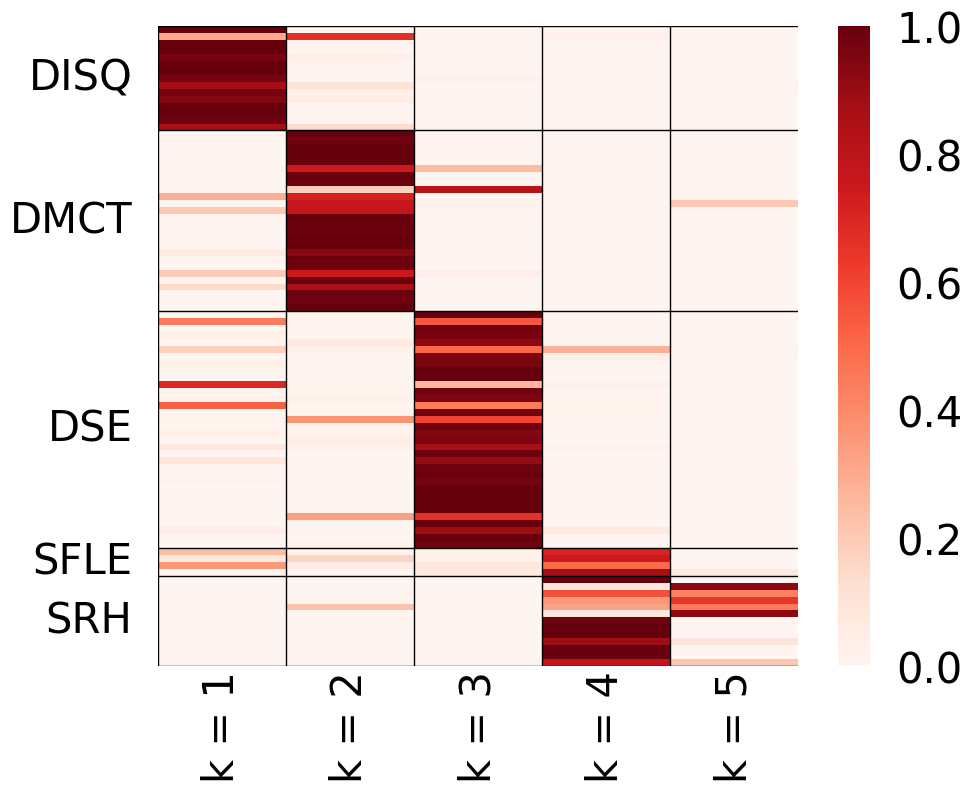

In [13]:
# Visualize inferred membership matrix.

comm_vis.inferred_membership_matrix(G, data_name, settings, U, W)

In [14]:
# Inferred affinity matrix.

W.shape, W

((5, 5),
 array([[1.07974399e-01, 7.07780921e-05, 1.40593271e-07, 7.68546732e-05,
         9.01768772e-06],
        [7.07780921e-05, 2.13140435e-01, 3.01226139e-08, 1.22383124e-03,
         3.59291310e-05],
        [1.40593271e-07, 3.01226139e-08, 3.87359498e-02, 3.16102534e-01,
         2.24390199e-07],
        [7.68546732e-05, 1.22383124e-03, 3.16102534e-01, 2.51215466e-06,
         2.47604804e-06],
        [9.01768772e-06, 3.59291310e-05, 2.24390199e-07, 2.47604804e-06,
         6.81205726e-02]]))

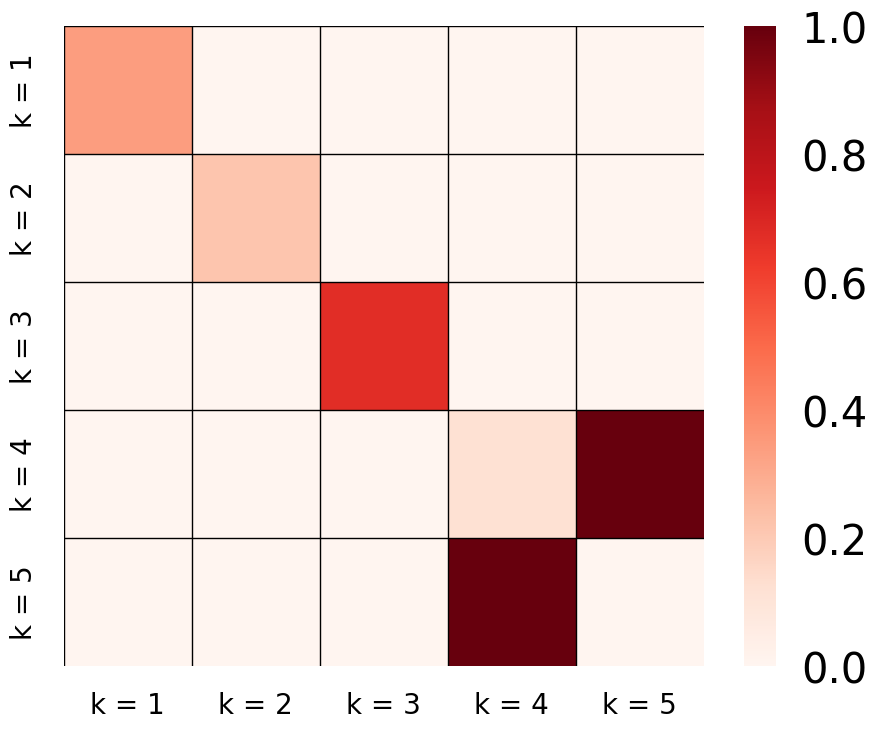

In [15]:
# Visualize inferred affinity matrix.

comm_vis.inferred_affinity_matrix(G, data_name, settings, U, W)

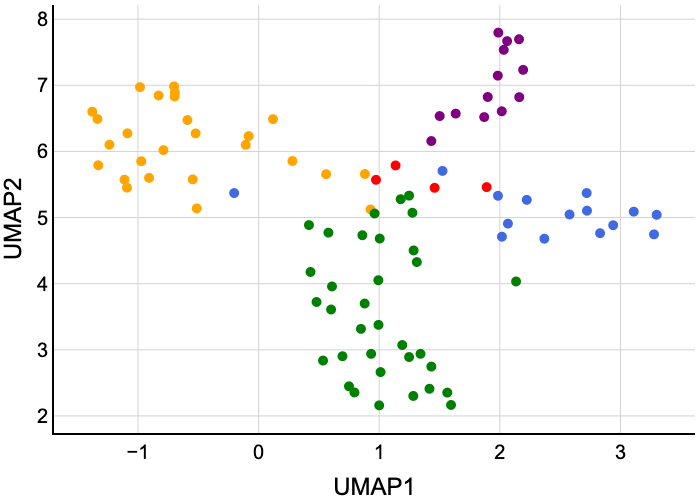

In [16]:
# Map the nodes into a two-dimensional vector space using the inferred membership and affinity matrices.
# We use the Euclidean distance in the UMAP.

comm_vis.node_layout(G, data_name, settings, U, W, metric="euclidean")

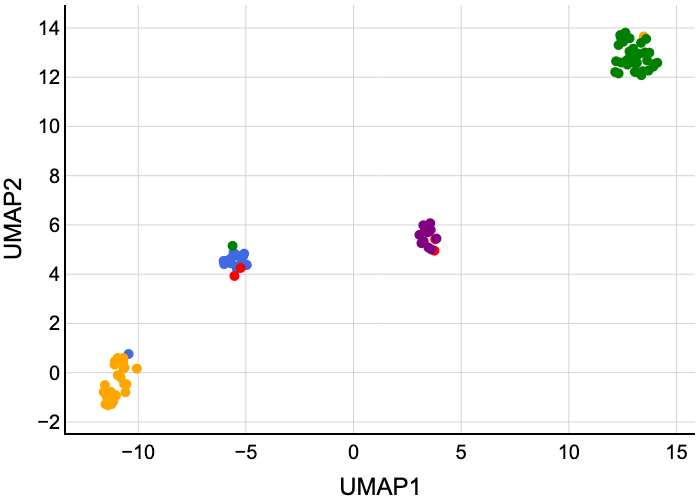

In [17]:
# Map the nodes into a two-dimensional vector space using the inferred membership and affinity matrices.
# We use the cosine distance in the UMAP.

comm_vis.node_layout(G, data_name, settings, U, W, metric="cosine")